<a href="https://colab.research.google.com/github/psbhargava/CarDent-Mask-Assessment/blob/master/CarScratch_Using_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## https://github.com/ravising-h/Car-Damage-Detection-Using-Detectron

# Install Detectron2, dependencies

In [0]:
!rm -r sample_data

In [0]:
! pip install -U torch torchvision cython
! pip install -U git+https://github.com/facebookresearch/fvcore.git 
! pip install -U git+https://github.com/cocodataset/cocoapi.git      #subdirectory=PythonAPI'

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.4.0)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.5.0)
Requirement already up-to-date: cython in /usr/local/lib/python3.6/dist-packages (0.29.16)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-znu39cm0
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-znu39cm0
     |████████████████████████████████| 276kB 9.0MB/s 
  Created wheel for fvcore: filename=fvcore-0.1-cp36-none-any.whl size=43738 sha256=0659cb619525a26bfaf3e91281fad9d9d6a48d5b9cedb74a2b3bf8969a27dade
  Stored in directory: /tmp/pip-ephem-wheel-cache-w5epymo9/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=850f9b0fd2dad7ffe8c252eb0b3b23132c7a8f873eb6094c7d3bd16237000ad2
  Stored in directory: /root/.cache/pip/wh

In [0]:
import torch, torchvision
print(torch.__version__)

1.4.0


In [0]:
! git clone https://github.com/facebookresearch/detectron2 detectron2_repo
! pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 3870 (delta 10), reused 23 (delta 10), pack-reused 3827
Receiving objects: 100% (3870/3870), 2.26 MiB | 3.80 MiB/s, done.
Resolving deltas: 100% (2669/2669), done.
Obtaining file:///content/detectron2_repo
  Running setup.py develop for detectron2


In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [Car Damage Detection Dataset](https://github.com/priya-dwivedi/Deep-Learning/tree/master/mask_rcnn_damage_detection/customImages)
which only has one class: damage.
We'll train a damage segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "damage" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

Register the balloon dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [0]:
!git clone https://github.com/priya-dwivedi/Deep-Learning

Cloning into 'Deep-Learning'...
remote: Enumerating objects: 382, done.
remote: Counting objects: 100% (382/382), done.
remote: Compressing objects: 100% (284/284), done.
remote: Total 3282 (delta 108), reused 354 (delta 91), pack-reused 2900
Receiving objects: 100% (3282/3282), 368.55 MiB | 31.04 MiB/s, done.
Resolving deltas: 100% (849/849), done.
Checking out files: 100% (3438/3438), done.


In [0]:
import os
import json
import itertools
import numpy as np
from detectron2.structures import BoxMode


# write a function that loads the dataset into detectron2's standard format
def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(list(imgs_anns.values())[3:]):
        record = {}
        
          
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = list(itertools.chain.from_iterable(poly))

            obj = { "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],"bbox_mode": BoxMode.XYXY_ABS,
                   "segmentation": [poly],"category_id": 0,"iscrowd": 0 }

            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
        
    return dataset_dicts


In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog
path = "/content/Deep-Learning/mask_rcnn_damage_detection/customImages"
for d in ["train", "val"]:
    DatasetCatalog.register(path +"/" + d, lambda d=d: get_balloon_dicts(path+"/"  + d))
    MetadataCatalog.get(path+"/" + d).set(thing_classes=["damage"])
balloon_metadata = MetadataCatalog.get("car_damage")

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



{'fileref': '', 'size': 47277, 'filename': 'image67.jpg', 'base64_img_data': '', 'file_attributes': {}, 'regions': {'0': {'shape_attributes': {'name': 'polygon', 'all_points_x': [298, 327, 346, 369, 522, 512, 488, 393, 307, 288, 298], 'all_points_y': [199, 203, 241, 265, 246, 290, 320, 322, 318, 264, 199]}, 'region_attributes': {'name': 'damage'}}, '1': {'shape_attributes': {'name': 'polygon', 'all_points_x': [241, 237, 220, 193, 150, 173, 212, 247, 248, 241], 'all_points_y': [167, 172, 194, 199, 206, 210, 202, 184, 165, 167]}, 'region_attributes': {'name': 'damage'}}}}
0 {'shape_attributes': {'name': 'polygon', 'all_points_x': [298, 327, 346, 369, 522, 512, 488, 393, 307, 288, 298], 'all_points_y': [199, 203, 241, 265, 246, 290, 320, 322, 318, 264, 199]}, 'region_attributes': {'name': 'damage'}}
1 {'shape_attributes': {'name': 'polygon', 'all_points_x': [241, 237, 220, 193, 150, 173, 212, 247, 248, 241], 'all_points_y': [167, 172, 194, 199, 206, 210, 202, 184, 165, 167]}, 'region_attr

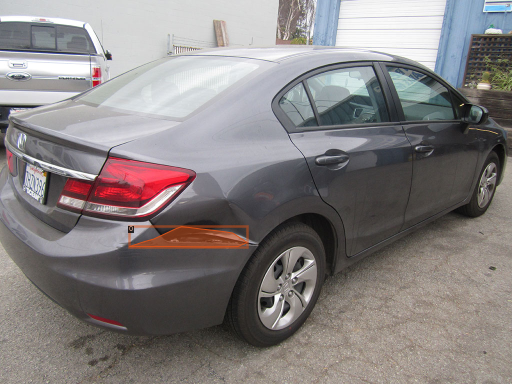

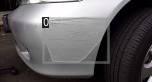

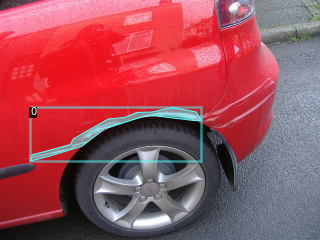

In [0]:
dataset_dicts = get_balloon_dicts(path + "/train")


for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = (path + "/train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/15 06:11:49 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:15, 11.8MB/s]                           
'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


[04/15 06:12:13 d2.engine.train_loop]: Starting training from iteration 0
[04/15 06:12:20 d2.utils.events]:  eta: 0:05:10  iter: 19  total_loss: 1.957  loss_cls: 0.806  loss_box_reg: 0.384  loss_mask: 0.690  loss_rpn_cls: 0.060  loss_rpn_loc: 0.015  time: 0.3167  data_time: 0.0168  lr: 0.000005  max_mem: 2672M
[04/15 06:12:26 d2.utils.events]:  eta: 0:04:58  iter: 39  total_loss: 1.845  loss_cls: 0.705  loss_box_reg: 0.353  loss_mask: 0.688  loss_rpn_cls: 0.063  loss_rpn_loc: 0.021  time: 0.3100  data_time: 0.0073  lr: 0.000010  max_mem: 2705M
[04/15 06:12:32 d2.utils.events]:  eta: 0:04:54  iter: 59  total_loss: 1.690  loss_cls: 0.570  loss_box_reg: 0.378  loss_mask: 0.680  loss_rpn_cls: 0.041  loss_rpn_loc: 0.019  time: 0.3122  data_time: 0.0094  lr: 0.000015  max_mem: 2705M
[04/15 06:12:38 d2.utils.events]:  eta: 0:04:48  iter: 79  total_loss: 1.572  loss_cls: 0.442  loss_box_reg: 0.392  loss_mask: 0.674  loss_rpn_cls: 0.033  loss_rpn_loc: 0.020  time: 0.3130  data_time: 0.0085  lr:

KeyboardInterrupt: ignored

In [0]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output
! kill 756

Reusing TensorBoard on port 6006 (pid 609), started 0:08:25 ago. (Use '!kill 609' to kill it.)

/bin/bash: line 0: kill: (756) - No such process


## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the damage validation dataset. First, let's create a predictor using the model we just trained:



In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85  # set the testing threshold for this model
cfg.DATASETS.TEST = (path + "/val", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

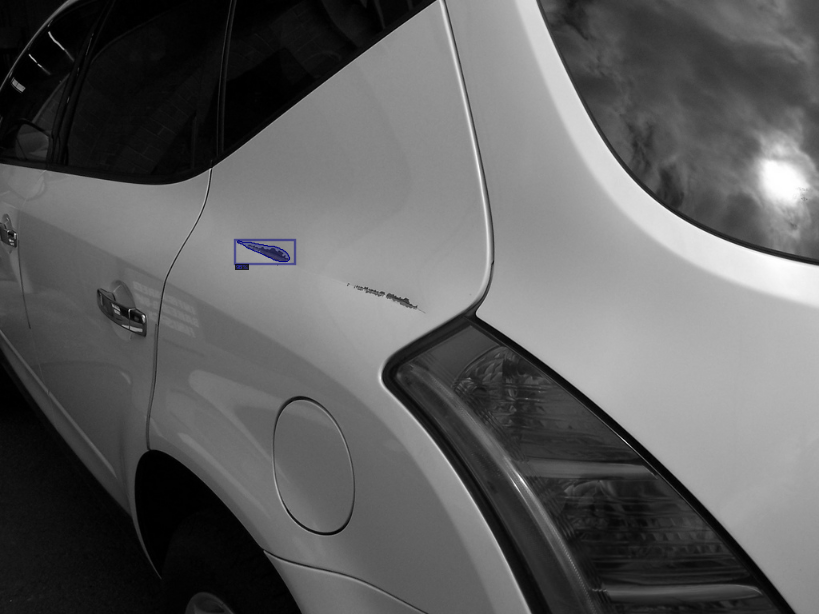

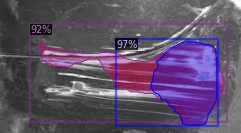

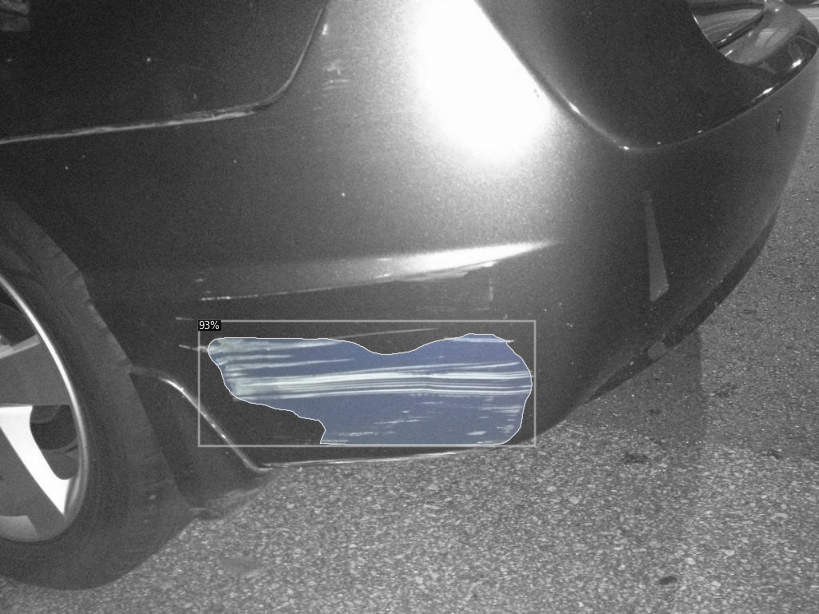

In [0]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts(path + "/val")

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [0]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

path = "/content/Deep-Learning/mask_rcnn_damage_detection/customImages"
evaluator = COCOEvaluator(path+ "/val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, path + "/val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [04/03 06:56:23 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for '/content/Deep-Learning/mask_rcnn_damage_detection/customImages/val'. Trying to convert it to COCO format ...
WARNING [04/03 06:56:23 d2.data.datasets.coco]: Using previously cached COCO format annotations at '/content/Deep-Learning/mask_rcnn_damage_detection/customImages/val_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[04/03 06:56:23 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   damage   | 14           |
|            |              |
[04/03 06:56:23 d2.data.common]: Serializing 12 elements to byte tensors and concatenating them all ...
[04/03 06:56:23 d2.data.common]: Serialized dataset takes 0.01 MiB
[04/03 06:56:23 d2.evaluation.evaluator]: Start inference on 12 images
[04/03 06:56:24 d2.evaluation.evaluator]: Inference done 11/12. 0.0701 s / img. ETA=0:00:

NameError: ignored